## Install required python packages:

In [ ]:
!pip install -e .

In [ ]:
!pip install -Ur requirements.txt

In [1]:
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import scienceplots
plt.style.use(["science"])
from IPython.display import Video
import cv2

## Functions to process data
from cvfem.dynamics import track_object, pos_to_accel, plot_results

## Functions to analyze data with system identification
from mdof import sysid, modes, modal, predict

['/opt/homebrew/Caskroom/miniforge/base/envs/ce249/lib/python3.9/site-packages/ipykernel_launcher.py', '--f=/Users/cchern/Library/Jupyter/runtime/kernel-v3e5a0d2092d2dd9fa94e1068fb1c06dca87f9708d.json']


# Two-Story Building: Estimate a Linear System (video data)

## 1. Experimental Setup and Data Collection

<div>
<img src="Uploads/setup_4.png" width="250"/>
</div>

### Collected Data

| No. | Motion         | Amplitude (cm) | Frequency (Hz) | Frames per second (fps) | Filename (Uploads/...) |
|-----|----------------|----------------|----------------|-------------------------|---------------------------|
| 1   | sine wave      | 1.0            | 1.0            | 60                      | sine_1.0_1.0_1.MOV        |
| 2   | sine wave      | 1.0            | 1.0            | 60                      | sine_1.0_1.0_2.MOV        |
| 3   | sine wave      | 1.0            | 1.0            | 240                     | sine_1.0_1.0_S.MOV        |
| 4   | sine wave      | 1.0            | 2.0            | 60                      | sine_1.0_2.0_1.MOV        |
| 5   | sine wave      | 1.0            | 2.0            | 60                      | sine_1.0_2.0_2.MOV        |
| 6   | sine wave      | 0.5            | 3.0            | 60                      | sine_0.5_3.0_1.MOV        |
| 7   | sine wave      | 0.5            | 3.0            | 60                      | sine_0.5_3.0_2.MOV        |
| 8   | Northridge EQ  | N/A            | N/A            | 60                      | northridge_1.MOV          |
| 9   | Northridge EQ  | N/A            | N/A            | 60                      | northridge_2.MOV          |
| 10  | Northridge EQ  | N/A            | N/A            | 240                     | northridge_S.MOV          |
| 11  | Kobe EQ        | N/A            | N/A            | 60                      | kobe_1.MOV                |
| 12  | Kobe EQ        | N/A            | N/A            | 60                      | kobe_2.MOV                |
| 13  | Mendocino EQ   | N/A            | N/A            | 60                      | mendocino_1.MOV           |
| 14  | Mendocino EQ   | N/A            | N/A            | 60                      | mendocino_2.MOV           |
| 15  | El Centro EQ   | N/A            | N/A            | 60                      | elcentro_1.MOV            |
| 16  | El Centro EQ   | N/A            | N/A            | 60                      | elcentro_1.MOV            |
| 17  | El Centro EQ   | N/A            | N/A            | 240                     | elcentro_S.MOV            |

In [2]:
DATA_DIR = Path('Uploads')
OUT_DIR = Path('out')
if not OUT_DIR.exists():
    OUT_DIR.mkdir()

COLLECTED_DATA = {
    1 : ['sine wave',       1.0,   1.0,  60 , 'sine_1.0_1.0_1.MOV'],
    2 : ['sine wave',       1.0,   1.0,  60 , 'sine_1.0_1.0_2.MOV'],
    3 : ['sine wave',       1.0,   1.0,  240, 'sine_1.0_1.0_S.MOV'],
    4 : ['sine wave',       1.0,   2.0,  60 , 'sine_1.0_2.0_1.MOV'],
    5 : ['sine wave',       1.0,   2.0,  60 , 'sine_1.0_2.0_2.MOV'],
    6 : ['sine wave',       0.5,   3.0,  60 , 'sine_0.5_3.0_1.MOV'],
    7 : ['sine wave',       0.5,   3.0,  60 , 'sine_0.5_3.0_2.MOV'],
    8 : ['Northridge EQ',   None,  None, 60 , 'northridge_1.MOV'  ],
    9 : ['Northridge EQ',   None,  None, 60 , 'northridge_2.MOV'  ],
    10: ['Northridge EQ',   None,  None, 240, 'northridge_S.MOV'  ],
    11: ['Kobe EQ',         None,  None, 60 , 'kobe_1.MOV'        ],
    12: ['Kobe EQ',         None,  None, 60 , 'kobe_2.MOV'        ],
    13: ['Mendocino EQ',    None,  None, 60 , 'mendocino_1.MOV'   ],
    14: ['Mendocino EQ',    None,  None, 60 , 'mendocino_2.MOV'   ],
    15: ['El Centro EQ',    None,  None, 60 , 'elcentro_1.MOV'    ],
    16: ['El Centro EQ',    None,  None, 60 , 'elcentro_1.MOV'    ],
    17: ['El Centro EQ',    None,  None, 240, 'elcentro_S.MOV'    ],
}

### Sine wave with amplitude of 1.0 cm and frequency of 2.0 Hz

In [3]:
Video(DATA_DIR/'sine_1.0_2.0_1.MOV', width=200)

### Northridge Earthquake

In [4]:
Video(DATA_DIR/'northridge_1.MOV', width=200)

## 2. Process Data: Video Tracking

In [5]:
def plot_and_save(record_index, scale_factor):
    """
    Use the cvfem helper functions, track_object,
    pos_to_accel, and plot_results to plot and 
    save the motion of the floors of the building
    model in the video.
    """
    # Path to your .MOV video
    video_path = DATA_DIR/COLLECTED_DATA[record_index][4]
    # Track the building's movement (e.g., a corner of the building)
    pos, fps = track_object(video_path, n_roi=3)
    print(f"Record {record_index}: {fps=}")
    # Calculate displacement, velocity, and acceleration
    displ, veloc, accel = pos_to_accel(pos, fps, scale_factor=scale_factor)
    # Plot the results
    time = np.arange(len(displ)) / fps
    result_fig = plot_results(time, displ, veloc, accel)
    # Save the results
    result_fig.savefig(OUT_DIR/f"{record_index}.png")
    np.savetxt(OUT_DIR/(f"{record_index}.csv"),displ[:,:,0])

### Sine wave with amplitude 1.0 cm and frequency of 2.0 Hz

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Record 4: fps=59.70345963756178


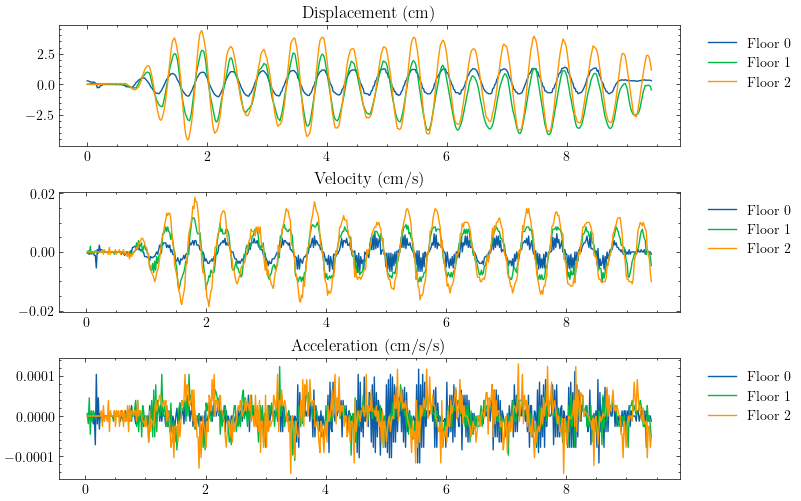

In [6]:
# Choose a record index (e.g. 1 if sine_1.0_1.0_1.MOV and 8 if northridge_1.MOV)
record_index = 4
# Scale factor (cm/pixel) of video
SCALE_FACTOR = 50/1080

plot_and_save(record_index=record_index, scale_factor=SCALE_FACTOR)

### Northridge earthquake

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Record 8: fps=59.80045059542967


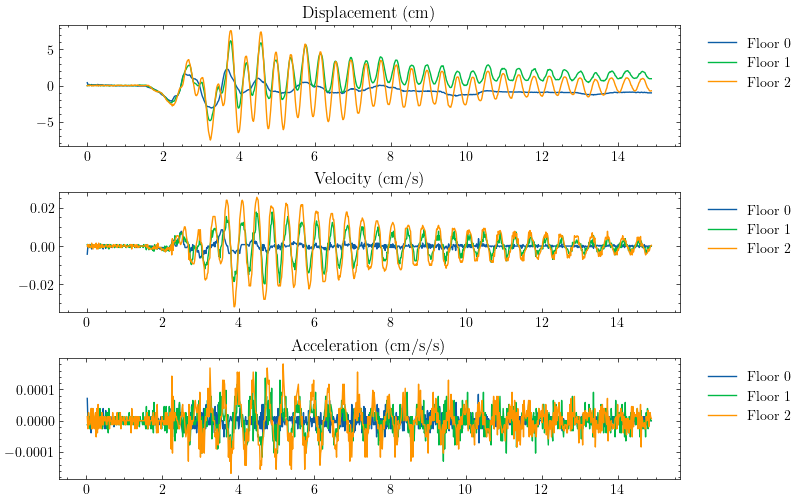

In [7]:
# Choose a record index (e.g. 1 if sine_1.0_1.0_1.MOV and 8 if northridge_1.MOV)
record_index = 8

plot_and_save(record_index=record_index, scale_factor=SCALE_FACTOR)

## 3. Analyze Data: System Identification

In [8]:
import mdof.utilities
from mdof import modes
for record_index in [4,8]:
    print(COLLECTED_DATA[record_index][0:5:4])
    displ = np.loadtxt(OUT_DIR/(f"{record_index}.csv"))
    inputs = displ[:,0].T
    outputs = displ[:,1:].T
    realization = sysid(inputs=inputs, outputs=outputs, order=6)
    mymodes = modal.system_modes(realization, dt=1/60)
    mdof.utilities.print_modes(mymodes)

['sine wave', 'sine_1.0_2.0_1.MOV']
Spectral quantities:
       T(s)        ζ        EMACO      MPC       EMACO*MPC
      0.5882     0.8515     1.0        0.9269     0.9269   
      0.5008     0.02836    1.0        0.9914     0.9914   
      0.401      0.2381     1.0        0.8649     0.8649   
Mean Period(s): 0.49664884611380417
Standard Dev(s): 0.07647222577813184
['Northridge EQ', 'northridge_1.MOV']
Spectral quantities:
       T(s)        ζ        EMACO      MPC       EMACO*MPC
      11.76      -0.1413    1.0        0.9791     0.9791   
      0.4041     0.002574   1.0        1.0        1.0      
      0.3897     0.0169     1.0        0.9992     0.9992   
Mean Period(s): 4.185805179841551
Standard Dev(s): 5.358275913623765


### From a model fitted to Northridge, predict the output of the sine wave.

In [9]:
# Fit a model to the Northridge data
displ_northridge = np.loadtxt(OUT_DIR/(f"8.csv"))
inputs_northridge = displ_northridge[:,0].T
outputs_northridge = displ_northridge[:,1:].T
realization = sysid(inputs=inputs_northridge, outputs=outputs_northridge, order=6)

In [10]:
# Predict the output of the sine wave
displ_sine = np.loadtxt(OUT_DIR/(f"4.csv"))
inputs_sine = displ_sine[:,0].T
actual_outputs_sine = displ_sine[:,1:].T
from mdof import predict
estimated_outputs_sine = predict(realization, inputs=inputs_sine)

Text(0.5, 0.98, 'Floor 2 Prediction')

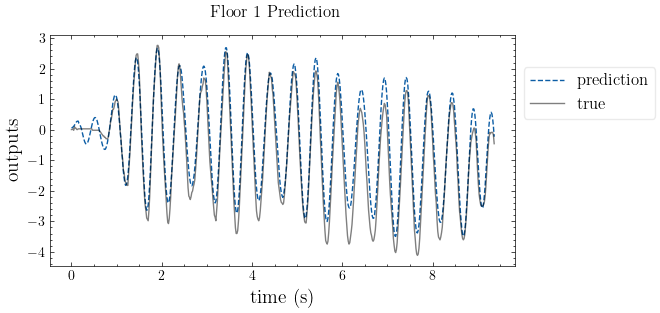

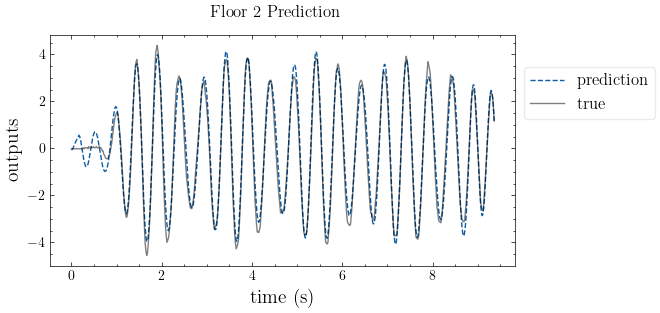

In [11]:
from mdof.utilities.printing import plot_pred
fig1 = plot_pred(ytrue=actual_outputs_sine[0], models=estimated_outputs_sine[0], t=np.arange(0,(1/60*(estimated_outputs_sine.shape[1])),1/60))
fig1.suptitle('Floor 1 Prediction')
fig2 = plot_pred(ytrue=actual_outputs_sine[1], models=estimated_outputs_sine[1], t=np.arange(0,(1/60*(estimated_outputs_sine.shape[1])),1/60))
fig2.suptitle('Floor 2 Prediction')